# Advanced Machine Learning - programming assignment 4

*Due: Friday January 28*

**Please fill in:**
* Grady, Idan (7304447)
* Kirschstein Schäfer, Oscar Alexander (1164783)

### Further instructions:
* Make sure your code is properly commented.
* Submit your code in Blackboard using one of your accounts; we will put the grade in Blackboard for the other team member as well.
* **Make sure to name the submitted file according to your and your collaborators last name.** (`submitter_collaborator.ipynb`)

## Implementing the PC algorithm
In this assignment, you will complete an implementation of the PC algorithm. After that, you will use it to discover causal relations in a data set. Each of these two parts is worth 5 points.

The PC algorithm will need to keep track of a PDAG. We will represent this PDAG by a numpy array `G` of booleans.

The matrix `G` represents a graph as follows:
* For all `x`, `G[x,x] == False`
* `G[x,y] == False` and `G[y,x] == False` means: no edge between x and y
* `G[x,y] == True` and `G[y,x] == True` means: an undirected edge x&mdash;y
* `G[x,y] == True` and `G[y,x] == False`means: a directed edge x $\to$ y

In [1]:
import numpy as np
from itertools import combinations
import graphviz # Install with: conda install python-graphviz

from AML_assignment4_util import *

The graphviz can draw graphs to different file formats, or show them directly in the notebook. The function `graph_to_graphviz(G, node_names)` converts a numpy array of the form described above to a graph in graphviz format. 

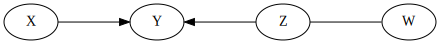

In [2]:
# Demonstration of graph_to_graphviz:
node_names = ['X', 'Y', 'Z', 'W']
G1 = np.zeros((4,4), dtype=bool)
G1[0,1] = G1[2,1] = True # two directed edges
# G1[1,0] = G1[1,2] = True # two directed edges
G1[2,3] = G1[3,2] = True # an undirected edge
d = graph_to_graphviz(G1, node_names)
d # must be final line of code block to be displayed

Here is a Python class for performing the PC algorithm (when an object of this class is created and its `run` function is called). Add the missing code for phase 2, and implement phases 3 and 4. In the next section, you'll find some test cases to see if your code runs without errors and does what you expect it to.

In [3]:
class PC_algorithm:
    def __init__(self, independence_tester, verbose=0):
        # verbose can be 0 (silent), 1 (report independences), or 2 (also report dependences)
        self.independence_tester = independence_tester
        self.n = independence_tester.n_observed
        self.node_names = independence_tester.node_names
        self.verbose = verbose
        self.G = np.logical_not(np.eye(self.n, dtype=bool))
        self.sepset = dict()
    
    def skeleton_search(self):
        # PHASE II: Skeleton search
        # Note: Adj(X) in the slides means: all nodes adjacent to X in the current graph G
        for k in range(self.n-1):
            for x in range(self.n):
                for y in range(self.n):
                    if not self.G[x,y]: #Adjacency check
                        continue
                    # Try all subsets S of Adj(x) \ {y} with |S|=k,
                    # until an independence is found.
                    # Hint: use itertools.combinations

                    # Your code here (1 point)
                    adj_x = [adj for adj in range(self.n) if (self.G[adj,x] and adj != y)]
                    for S in [s for s in combinations(adj_x, k)]: # replace this line by your code
                        indep = self.independence_tester.test_independence(x, y, S)
                        if indep:
                            if self.verbose >= 1:
                                print("independence found: {0} and {1} given {{{2}}}"
                                      .format(self.node_names[x], self.node_names[y],
                                              ", ".join([self.node_names[v] for v in S])))
                            # Remove this edge.
                            self.G[x,y] = self.G[y,x] = False
                            # We use frozensets as keys in the dictionary self.sepset,
                            # because ordinary sets can't be used as keys to dictionaries.
                            self.sepset[frozenset([x,y])] = S
                            break
                        else:
                            if self.verbose >= 2:
                                print("dependence found: {0} and {1} given {{{2}}}"
                                      .format(self.node_names[x], self.node_names[y],
                                              ", ".join([self.node_names[v] for v in S])))

            # Do we need to continue with larger k?
            max_S_size = np.sum(self.G, axis=0) - 1
            if np.all(max_S_size < k + 1):
                break
        return

    def orient_v_structures(self):
        # PHASE III: Orient v-structures
        # Something to watch out for:
        # If the data are not faithful to any graph, the algorithm may end up trying
        # to orient a single edge in two different ways. You can choose either
        # orientation if this happens. But make sure not to accidentally delete such an edge!
        for [x, y] in self.sepset.keys():
            for z in range(self.n):
                adjacent = self.G[z,x] and self.G[z,y]
                if not adjacent: # Check if Z is adjacent to both X and Y
                    continue 
                sepset = self.sepset[frozenset([x,y])]
                if z in sepset: # Check if Z is in SepSet({X,Y})
                    continue

                # If Z is adjacent to both and Z is not in their separation set
                # Then mark Z is a collider
                
                self.G[z,x] = self.G[z,y] = False
                self.G[x,z] = self.G[y,z] = True
        return
    
    def orientation_rules(self):
        # PHASE IV: Orientation rules
        """
        Rule 1: If Z->X--Y and (Z,Y) not adjacent, then X->Y
        Rule 2: X -> Z -> Y and X--Y, then X -> Y
        Rule 3: X -- Z and W and (Z,W) not adjacent, but Z,W --> Y and X -- Y then X -> Y
        """
        r1 = r2 = r3 = True
        while any([r1, r2, r3]):
            r1 = r2 = r3 = False
            r1 = self.rule1()
            r2 = self.rule2()
            r3 = self.rule3()

        return

    def directed(self,x,y):
        return self.G[x,y] and not self.G[y,x]

    def bidirectional(self, x, y):
        return self.G[x,y] and self.G[y,x]

    def adjacent(self, x, y):
        return self.G[x,y] or self.G[y,x]
    
    def add_directed(self, x, y):
        self.G[y,x] = False

    def is_any_equal(self, nodes):
        for (x,y) in combinations(nodes, 2):
            if x == y: return True
        return False

    def rule1(self):
        applied_r1 = False

        for x in range(self.n):
            for y in range(self.n):
                for z in range(self.n):
                    if self.is_any_equal([x,y,z]):
                        continue
                    if not self.adjacent(z, y) and self.directed(z, x) and self.bidirectional(x,y):
                        self.add_directed(x,y)
                        applied_r1 = True
                        
        
        return applied_r1
                

    def rule2(self):
        applied_r2 = False
        
        for x in range(self.n):
            for y in range(self.n):
                for z in range(self.n):
                    if self.is_any_equal([x,y,z]):
                        continue
                    if self.directed(x,z) and self.directed(z,y) and self.bidirectional(x,y):
                        self.add_directed(x,y)
                        applied_r2 = True
        
        return applied_r2

    def rule3(self):
        applied_r3 = False

        for x in range(self.n):
            for y in range(self.n):
                for z in range(self.n):
                    for w in range(self.n):
                        if self.is_any_equal([x,y,z,w]):
                            continue
                        if self.directed(z,y) and self.directed(w,y) and self.bidirectional(x,y) and \
                        self.bidirectional(x,z) and self.bidirectional(x,w):
                            self.add_directed(x,y)
                            applied_r3 = True

        return applied_r3
                        


    def run(self):
        # The initialization step has already been performed by the __init__ method.
        # Perform the other phases one by one. Each of the following functions
        # modifies self.G, which represents the graph.
        self.skeleton_search()
        self.orient_v_structures()
        self.orientation_rules()

        return self.G

## Testing the PC implementation

To verify that the algorithm is working correctly, we will feed it output from an *oracle* instead of conditional independence test results from a data set. The oracle knows what the true graph is, and mimics the conditional independence test results that we would get for data that is Markov and faithful to that graph. In this situation, the PC algorithm will recover the Markov equivalence class of the true graph.

In [4]:
class IndependenceOracle:
    def __init__(self, true_G, node_names, n_observed=None):
        self.G = true_G
        self.n = true_G.shape[0]
        self.n_observed = n_observed if n_observed is not None else self.n
        self.node_names = node_names
    def test_independence(self, x, y, S):
        S_mask = np.zeros(self.n, dtype=bool)
        np.put(S_mask, S, True)
        return is_d_separated(self.G, x, y, S_mask)

We will compare the output of PC to the oracle's true graph for the graph `G1` we saw before, and for several other graphs. (You can add more tests to help chase down any bugs.)

PASS


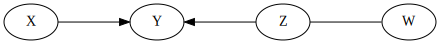

In [5]:
oracle = IndependenceOracle(G1, node_names)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if np.all(G == G1) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

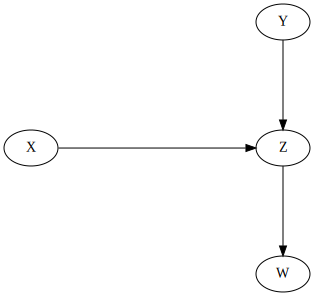

In [6]:
G2 = np.zeros((4,4), dtype=bool)
G2[0,2] = G2[1,2] = G2[2,3] = True
graph_to_graphviz(G2, node_names)

PASS


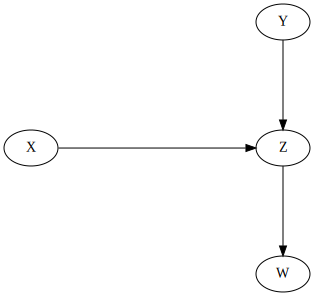

In [7]:
oracle = IndependenceOracle(G2, node_names)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if np.all(G == G2) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

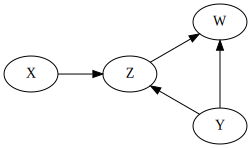

In [8]:
G3 = np.zeros((4,4), dtype=bool)
G3[0,2] = G3[1,2] = G3[1,3] = G3[2,3] = True
graph_to_graphviz(G3, node_names)

PASS


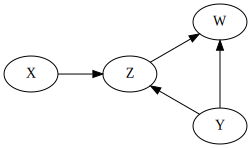

In [9]:
oracle = IndependenceOracle(G3, node_names)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if np.all(G == G3) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

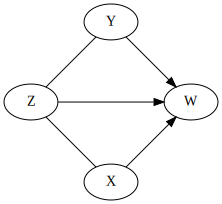

In [10]:
G4 = np.logical_not(np.eye(4, dtype=bool))
G4[0,1] = G4[1,0] = False
G4[3,0] = G4[3,1] = G4[3,2] = False
graph_to_graphviz(G4, node_names)

PASS


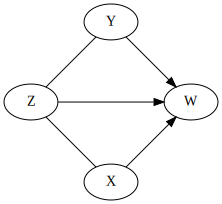

In [11]:
oracle = IndependenceOracle(G4, node_names)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if np.all(G == G4) else "FAIL")
graph_to_graphviz(G, oracle.node_names)

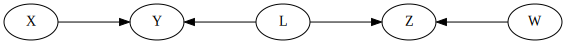

In [12]:
# Example of a case for which no DAG exists that is Markov and faithful to the distribution.
# L is a latent variable that the PC algorithm won't know about. PC's output should be either
# X --> Y --> Z <-- W or
# X --> Y <-- Z <-- W.
# If there is no edge between Y and Z in your output, this most likely indicates a bug in
# your implementation of phase III.
G5 = np.zeros((5,5), dtype=bool)
G5[0,1] = G5[4,1] = True
G5[3,2] = G5[4,2] = True
graph_to_graphviz(G5, ['X', 'Y', 'Z', 'W', 'L'])

PASS


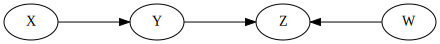

In [13]:
oracle = IndependenceOracle(G5, node_names, n_observed = 4)
A = PC_algorithm(oracle)
G = A.run()
print("PASS" if G[0,1] and G[3,2] and (G[1,2] or G[2,1]) and np.sum(G) == 3 else "FAIL")
graph_to_graphviz(G, oracle.node_names)

## Running PC on data
In this second part of the assignment, you will apply the PC algorithm to the biological dataset of Sachs et al. (2005). In this dataset, the columns represent 11 different proteins, which were measured in thousands of human immune system cells. Each row is a single cell. The cells were prepared in different ways, by adding different chemicals some time before the measurements were made. A twelfth column, labeled `experiment`, indicates in which way that cell was prepared. We can think of `experiment=1` as denoting the observational data, and other values of `experiment` (2 through 14) as various interventional datasets.

In [14]:
import pandas as pd

all_data = pd.read_csv("sachs2005_combined.csv", sep='\t')
# Transform all columns except 'experiment' by taking the logarithm of 10 + the original value
all_data.loc[:, all_data.columns != 'experiment'] = np.log(10 + all_data.loc[:, all_data.columns != 'experiment'])

We will apply the PC algorithm to just the observational data.

Make a new dataframe containing only the data where experiment equals 1. Remove the `experiment` column from this dataframe. Check the shape of your dataframe: it should be `(853, 11)`.

In [18]:
# Your code here (0.5 point)
observational_data = all_data[all_data.experiment == 1].drop('experiment',axis=1)

In [35]:
observational_data

,praf,pmek,plcg,PIP2,PIP3,perk,pakts473,PKA,PKC,P38,pjnk
0,3.594569,3.144152,2.934920,3.342862,4.231204,2.810005,3.295837,6.049733,3.295837,4.005513,3.912023
1,3.826465,3.277145,3.104587,3.288402,2.897568,3.353407,3.749504,5.891644,2.593013,3.277145,4.269697
2,4.239887,3.990834,3.202746,3.005683,3.135494,3.214868,3.749504,6.023448,3.063391,3.735286,3.384390
3,4.418841,4.530447,3.499533,3.157000,2.423917,2.761907,3.081910,6.287859,3.165475,3.653252,3.499533
4,3.777348,3.394508,2.720637,2.982140,3.549617,3.437208,4.027136,5.752573,2.685123,3.575151,4.514151
...,...,...,...,...,...,...,...,...,...,...,...
848,3.955082,3.627004,3.449988,4.355426,3.104587,2.905808,3.250374,6.349139,3.462606,3.681351,2.905808
849,4.278054,3.456317,2.973487,2.802754,3.790985,3.230804,3.499533,5.796058,3.086487,3.817712,4.109233
850,4.727388,3.742420,3.005683,3.144152,4.109233,2.726545,2.748552,5.517453,3.198673,3.493473,2.723267
851,4.473922,3.517498,3.549617,4.254193,3.998201,3.449988,3.555348,5.700444,3.742420,4.537961,3.613617


For the next part, you will need to install the package [tigramite](https://github.com/jakobrunge/tigramite). Here are three different ways in which you might be able to install it, in the order in which we recommend you to try them:

1. `conda install -c egilliesix tigramite`

2. `conda install git pip`  
`pip install git+git://github.com/jakobrunge/tigramite.git`

3. If not in a conda environment, follow the README on github.

To run the PC algorithm on data, we need to perform (conditional) independence tests. Tigramite implements several such tests. The simplest of these tests is `ParCorr()`. It assumes the data come from a linear structural causal model, which they actually don't. We will use it anyway, because the alternatives (such as `CMIknn()` (Runge, 2018)) are more effort to install and orders of magnitude slower, while `ParCorr()` usually already gives decent results.

As a statistical test, a conditional independence test works by computing a p-value. If a **conditional independence** exists, this *p-value* will be approximately *uniformly distributed* on the interval **between 0 and 1**. If the variables being tested are **conditionally dependent**, the *p-value* will be **close to 0**. PC wants to know a binary answer, so we will pick some threshold alpha and declare an independence if the p-value is larger than alpha.

In statistical testing, alpha is often taken to be 0.05 or smaller. For PC, it may be more appropriate to pick a larger alpha instead. This is because as soon as PC finds a (conditional) independence between two variables, it will delete the edge between them and do no more tests between those two variables. If this happens while it shouldn't have, PC can't put the edge back. But in the reverse situation, if PC leaves an edge in place while it should have deleted it, there is still a possibility that the edge will be deleted later, when another test between those two variables reports a more convincing independence.

In [16]:
from tigramite.independence_tests import ParCorr#, CMIknn
import tigramite.data_processing as pp
# Importing these may give some warnings (e.g. 'Could not import r-package RCIT'),
# but most of these warnings can be ignored because we are not using the mentioned packages.

class IndependenceTester:
    def __init__(self, data, cond_ind_test, alpha, verbose=2, n_observed=None):
        # data: a pandas dataframe
        # cond_ind_test: an independence test from tigramite, e.g. ParCorr()
        # alpha: the significance level to which the p-values are compared
        
        # tigramite uses its own kind of dataframe, so convert the data to that format
        df_tigramite = pp.DataFrame(data.to_numpy(), var_names=data.columns)
        self.cond_ind_test = cond_ind_test
        self.cond_ind_test.set_dataframe(df_tigramite)
        self.n = data.shape[1]
        self.n_observed = n_observed if n_observed is not None else self.n
        self.verbose = verbose
        self.node_names = data.columns
        self.alpha = alpha
    def test_independence(self, x, y, S):
        val, pval = self.cond_ind_test.run_test(X=[(x, 0)],
                                                Y=[(y, 0)],
                                                Z=[(z, 0) for z in S])
        test_result = pval > self.alpha
        if self.verbose >= 2 or (self.verbose >= 1 and test_result):
            print("test: {0} and {1} given {2} -> pval={3}".format(self.node_names[x], self.node_names[y],
                                                                   ", ".join([self.node_names[v] for v in S]),
                                                                   pval))
        return test_result

c:\Users\oscar\Documents\Master\1_2\Advanced ML\INFOMAML\.aml_ass\lib\site-packages\tigramite\independence_tests\gpdc.py:16: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
c:\Users\oscar\Documents\Master\1_2\Advanced ML\INFOMAML\.aml_ass\lib\site-packages\tigramite\independence_tests\gpdc_torch.py:18: UserWarning: No module named 'dcor'
  warnings.warn(str(e))


Using an IndependenceTester object (which works similarly to the IndependenceOracle we used earlier), run the PC algorithm on the observational data. Display the graph that comes out. You may experiment with different values of alpha; the graph you get should either be connected (i.e. consist of one connected component), or have just two connected components.

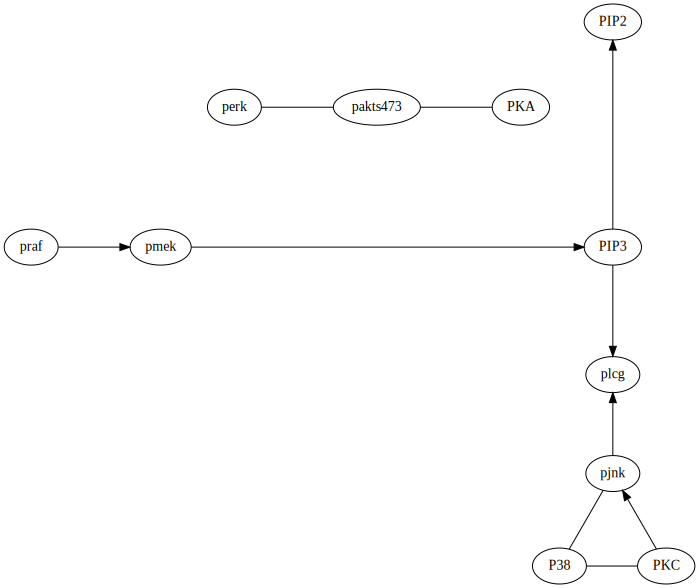

In [19]:
alpha = 0.097
ind_test = IndependenceTester(observational_data, ParCorr(), alpha, verbose=0)
A = PC_algorithm(ind_test)
G = A.run()
graph_to_graphviz(G, ind_test.node_names)

Now let's look at what else is in the dataset: the interventional data corresponding to different experiments. The PC algorithm did not look at this part of the dataset, but these additional experiments can obviously provide valuable information about the causal graph. In the following questions, we will investigate two examples of this. We will use the output of the PC algorithm to give us a rough idea of what the causal graph might look like.

The interventions in these experiment are not perfect interventions: they change the structural equation of a variable, but not by setting it to a constant. The new structural equation in the intervened model may still include all variables that were there in the original model. So in the graph of the intervened model, all arrows will still be there.

Further, some of the interventions change not one, but multiple structural equations.

For some of the interventions in the data, here is what they do according to many (but not all) experts:
* experiment 5 adds the substance psitectorigenin, which modifies the amount of PIP2;
* experiment 6 adds the substance U0126, which increases the *activity* of pmek. This means that the amount of pmek is not changed by the intervention, but for all *children* of pmek in the causal model, the structural equation changes to reflect that pmek now has a stronger effect on them. pmek is believed to have only one child in the true causal model, namely perk.

(Source: Mooij et al., 2019, specifically Tables 2 & 3 and Figure 35(a))

Create two new dataframes, one containing all data from experiments 1 and 5, and one with the data from experiments 1 and 6. These dataframes should still have an 'experiment' column, so that you can tell for each row whether it came from the observational or the interventional dataset.

In [20]:
# Your code here (0.5 point)
intervention5_data = all_data[(all_data.experiment == 1) | (all_data.experiment == 5)]
intervention6_data = all_data[(all_data.experiment == 1) | (all_data.experiment == 6)]

In [21]:
intervention5_data[intervention5_data.experiment == 5]

,praf,pmek,plcg,PIP2,PIP3,perk,pakts473,PKA,PKC,P38,pjnk,experiment
3389,3.895894,2.939162,2.657458,2.955951,2.474856,3.580737,4.036009,5.451038,2.566487,3.728100,4.324133,5
3390,3.962716,3.407842,3.095578,2.437990,3.912023,3.693867,4.125520,5.613128,2.768832,3.182212,3.261935,5
3391,2.765060,3.328627,2.597491,2.500616,3.335770,4.744932,5.736572,7.569412,2.832036,3.417727,3.131137,5
3392,3.790985,3.360375,2.613740,2.459589,3.277145,5.891644,6.270988,7.149132,3.342862,4.239887,3.826465,5
3393,3.543854,3.258097,2.828496,2.964757,2.893700,3.246491,4.155753,5.874931,2.960623,3.335770,3.113515,5
...,...,...,...,...,...,...,...,...,...,...,...,...
4194,4.262680,3.931826,2.636196,2.633327,3.394508,3.627004,3.998201,5.899897,3.660994,4.371976,3.804438,5
4195,4.387014,3.543854,2.397895,2.676215,3.968403,4.489759,5.105945,7.712891,2.636196,3.091042,3.770459,5
4196,4.284965,3.499533,2.590767,2.588516,3.190476,3.198673,3.627004,5.899897,3.325036,3.693867,2.595255,5
4197,4.812184,4.418841,2.397895,2.425687,3.068053,2.930660,3.716008,6.208590,3.912023,4.498698,3.983413,5


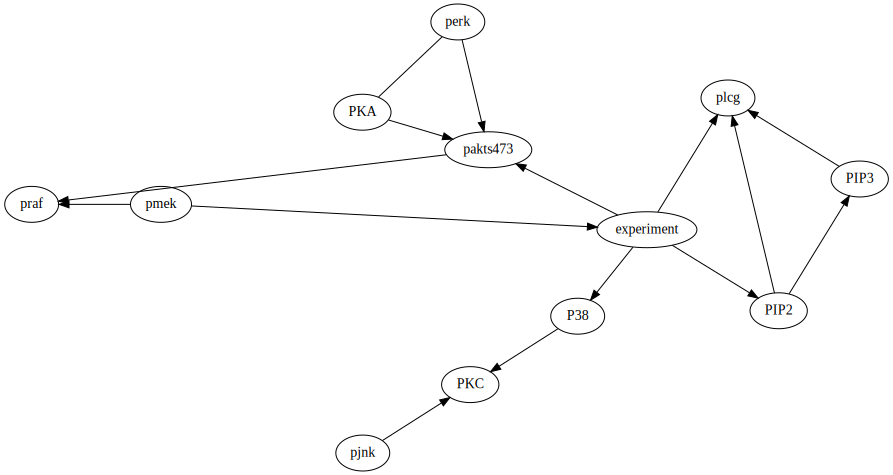

In [66]:
# Answer
alpha = 0.097
ind_test = IndependenceTester(intervention5_data, ParCorr(), alpha, verbose=0)
A = PC_algorithm(ind_test)
G = A.run()
graph_to_graphviz(G, ind_test.node_names)

**Question (1.5 points)**: In the dataframe for experiments 1 and 5, look at PIP2 and a variable adjacent to it in the output of PC (if there is more than one, pick one). Using about 200 words, answer the following questions: Based on looking at one or more plots (like scatterplots or histograms), which do you find more likely: that psitectorigenin directly modifies PIP2, or the neighbouring variable, or both? And what does the data for the two experiments seem to say about the direction of the arrow between PIP2 and its neighbour?

Insert one or more markdown and code boxes below here to give your answer and the plots you base your answer on. (Please put your answer in markdown boxes, not as comments in your code!)

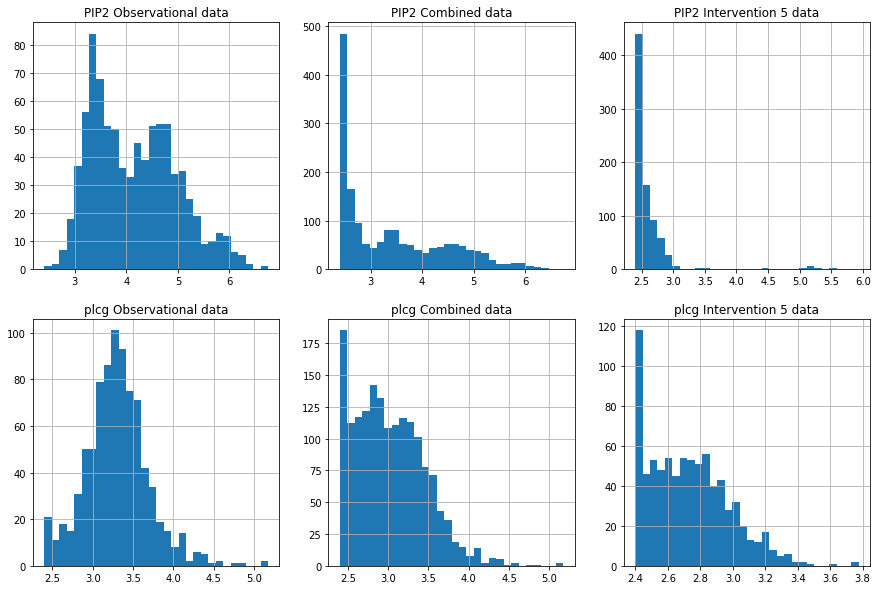

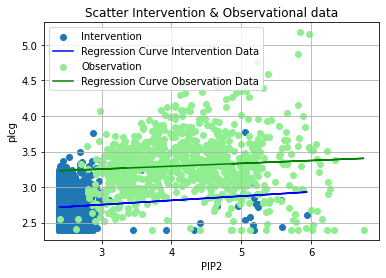

Slope observational correlation: 0.040103741693861085
Slope interventional correlation: 0.060209160931135805


In [73]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(15,10))
observational_data.PIP2.hist(bins=30, ax=ax[0][0])
# ax[0][0].axvline(observational_data.PIP2.mean(), color='red', linestyle='dashed', linewidth=1)
ax[0][0].set_title("PIP2 Observational data")
intervention5_data.PIP2.hist(bins=30, ax=ax[0][1])
ax[0][1].set_title("PIP2 Combined data")
intervention5_data[intervention5_data.experiment == 5].PIP2.hist(bins=30, ax=ax[0][2])
ax[0][2].set_title("PIP2 Intervention 5 data")

##################################################

observational_data.plcg.hist(bins=30, ax=ax[1][0])
ax[1][0].set_title("plcg Observational data")
intervention5_data.plcg.hist(bins=30, ax=ax[1][1])
ax[1][1].set_title("plcg Combined data")
intervention5_data[intervention5_data.experiment == 5].plcg.hist(bins=30, ax=ax[1][2])
ax[1][2].set_title("plcg Intervention 5 data")
plt.show()

##################################################



plt.scatter(intervention5_data[intervention5_data.experiment == 5].PIP2, intervention5_data[intervention5_data.experiment == 5].plcg, label='Intervention')
m_int, b = np.polyfit(np.squeeze(intervention5_data[intervention5_data.experiment == 5].PIP2), intervention5_data[intervention5_data.experiment == 5].plcg, 1)
plt.plot(np.squeeze(intervention5_data[intervention5_data.experiment == 5].PIP2), m_int*np.squeeze(intervention5_data[intervention5_data.experiment == 5].PIP2) + b, c="blue", label="Regression Curve Intervention Data")
plt.scatter(intervention5_data[intervention5_data.experiment == 1].PIP2, intervention5_data[intervention5_data.experiment == 1].plcg, c="lightgreen", label='Observation')
m_obs, b = np.polyfit(np.squeeze(observational_data.PIP2), observational_data.plcg, 1)
plt.plot(np.squeeze(observational_data.PIP2), m_obs*np.squeeze(observational_data.PIP2) + b, c="green", label="Regression Curve Observation Data")
plt.legend()
plt.title("Scatter Intervention & Observational data")
plt.xlabel("PIP2")
plt.ylabel("plcg")
plt.grid(True)

plt.show()
print(f"Slope observational correlation: {m_obs}")
print(f"Slope interventional correlation: {m_int}")

Slope interventional correlation: 0.1899239715492414


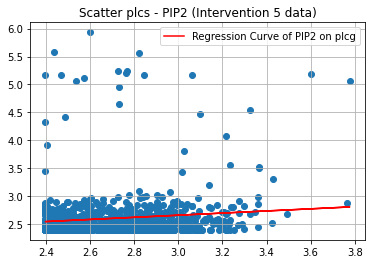

In [130]:
plt.scatter(intervention5_data[intervention5_data.experiment == 5].plcg, intervention5_data[intervention5_data.experiment == 5].PIP2)
m_int, b = np.polyfit(np.squeeze(intervention5_data[intervention5_data.experiment == 5].plcg), intervention5_data[intervention5_data.experiment == 5].PIP2, 1)
plt.plot(np.squeeze(intervention5_data[intervention5_data.experiment == 5].plcg), m_int*np.squeeze(intervention5_data[intervention5_data.experiment == 5].plcg) + b, c="red", label="Regression Curve of PIP2 on plcg")
plt.legend()
plt.title("Scatter plcs - PIP2 (Intervention 5 data)")
plt.grid(True)
print(f"Slope interventional correlation: {m_int}")

**Based on looking at one or more plots (like scatterplots or histograms), which do you find more likely: that psitectorigenin directly modifies PIP2, or the neighbouring variable, or both?**
The latter graphs were obtained with an alpha of 0.097. We chose to observe the adjacent variable 'plcg' . The graphs clearly depict that the intervention, introducing psitectorigenin, has an impact on the distributions of both of the proteins. We claim that psitectorigenin influences both PIP2 and plcg. One one hand, it seems that before the intervention, PIP2 had a normal distribution in values, as can be seen in the graph on the top left, while in experiment 5, it seems that the distribution is heavily skewed to the left. Moreover, the plcg distribution is also different prior and after the experiment, being skewing to the left. This can be further observed in the scatterplots, where the X axis represents the PIP2 presence in cells and the y axis represents the presence of plcg. Before the intervention, most of the of values for plcg are in the range of [3-3.5] and after it, they are more in the range of [2.4-2.8]. In the case of PIP2, it's even more noticeable, where the majority of the values are between 3 and 5, while after the intervention, they are around [2.5-3]. Furthermore, the range of values of PIP2 in the observational data is between 0 and 6, while after the experiment it seems that the values concentrate around 2.5, left-skewing towards 3.


**And what does the data for the two experiments seem to say about the direction of the arrow between PIP2 and its neighbour?**  
It is more likely that plcg is the cause of PIP2, even though the graph obtained by the PC algorithm sais the opposite. This assumption was made by comparing the regression line inverted scatterplots of PIP2 and plcg in the intervention data. Whereas the slope of the regression line of plcs over PIP2 is just 0.06, the slope of the regression line of PIP2 over plcs is 0.19. This suggest a more likely dependency of PIP2 on plcs.


**Question (1.5 points)**: In the dataframe for experiments 1 and 6, look at pmek, perk, and any other variables adjacent to pmek in the output of PC. Assume it is true that adding U0126 produces an intervention on the *activity* of pmek. What would you expect to see in the data if the graph found by PC was correct? Would you propose any changes to that graph based on the data?

Again put your answer (about 200 words) with accompanying plots in new boxes below here.

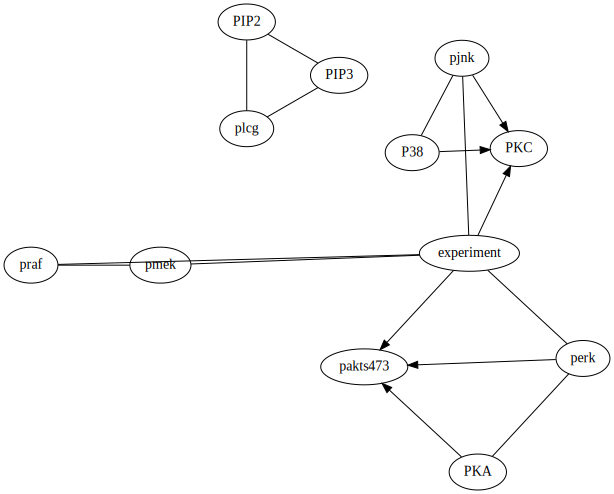

In [51]:
# Answer
alpha = 0.097
ind_test = IndependenceTester(intervention6_data, ParCorr(), alpha, verbose=0)
A = PC_algorithm(ind_test)
G = A.run()
graph_to_graphviz(G, ind_test.node_names)

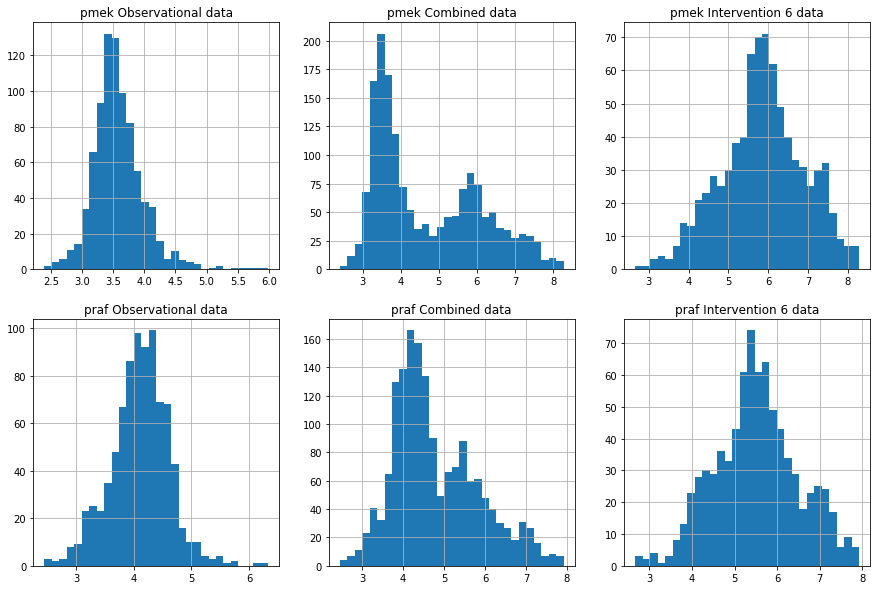

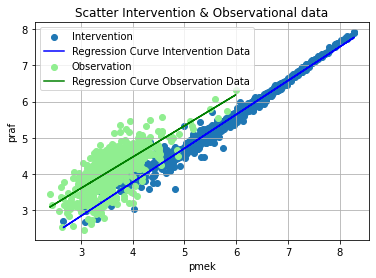

Slope observational correlation: 0.8641734011352789
Slope interventional correlation: 0.9362015665707624


In [70]:
fig, ax = plt.subplots(2, 3, figsize=(15,10))
observational_data.pmek.hist(bins=30, ax=ax[0][0])
ax[0][0].set_title("pmek Observational data")
intervention6_data.pmek.hist(bins=30, ax=ax[0][1])
ax[0][1].set_title("pmek Combined data")
intervention6_data[intervention6_data.experiment == 6].pmek.hist(bins=30, ax=ax[0][2])
ax[0][2].set_title("pmek Intervention 6 data")

##################################################

observational_data.praf.hist(bins=30, ax=ax[1][0])
ax[1][0].set_title("praf Observational data")
intervention6_data.praf.hist(bins=30, ax=ax[1][1])
ax[1][1].set_title("praf Combined data")
intervention6_data[intervention6_data.experiment == 6].praf.hist(bins=30, ax=ax[1][2])
ax[1][2].set_title("praf Intervention 6 data")
plt.show()

##################################################


plt.scatter(intervention6_data[intervention6_data.experiment == 6].pmek, intervention6_data[intervention6_data.experiment == 6].praf, label='Intervention')
m_int, b = np.polyfit(np.squeeze(intervention6_data[intervention6_data.experiment == 6].pmek), intervention6_data[intervention6_data.experiment == 6].praf, 1)
plt.plot(np.squeeze(intervention6_data[intervention6_data.experiment == 6].pmek), m_int*np.squeeze(intervention6_data[intervention6_data.experiment == 6].pmek) + b, c="blue", label="Regression Curve Intervention Data")
plt.scatter(intervention6_data[intervention6_data.experiment == 1].pmek, intervention6_data[intervention6_data.experiment == 1].praf, c="lightgreen", label='Observation')
m_obs, b = np.polyfit(np.squeeze(observational_data.pmek), observational_data.praf, 1)
plt.plot(np.squeeze(observational_data.pmek), m_obs*np.squeeze(observational_data.pmek) + b, c="green", label="Regression Curve Observation Data")
plt.legend()
plt.title("Scatter Intervention & Observational data")
plt.xlabel("pmek")
plt.ylabel("praf")
plt.grid(True)

plt.show()
print(f"Slope observational correlation: {m_obs}")
print(f"Slope interventional correlation: {m_int}")

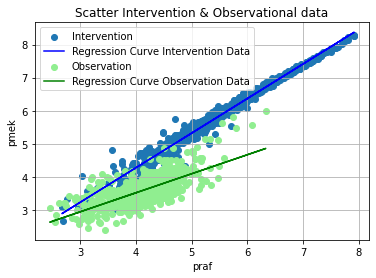

Slope observational correlation: 0.5745090415524344
Slope interventional correlation: 1.0445509915200104


In [57]:
plt.scatter(intervention6_data[intervention6_data.experiment == 6].praf, intervention6_data[intervention6_data.experiment == 6].pmek, label='Intervention')
m_int, b = np.polyfit(np.squeeze(intervention6_data[intervention6_data.experiment == 6].praf), intervention6_data[intervention6_data.experiment == 6].pmek, 1)
plt.plot(np.squeeze(intervention6_data[intervention6_data.experiment == 6].praf), m_int*np.squeeze(intervention6_data[intervention6_data.experiment == 6].praf) + b, c="blue", label="Regression Curve Intervention Data")
plt.scatter(intervention6_data[intervention6_data.experiment == 1].praf, intervention6_data[intervention6_data.experiment == 1].pmek, c="lightgreen", label='Observation')
m_obs, b = np.polyfit(np.squeeze(observational_data.praf), observational_data.pmek, 1)
plt.plot(np.squeeze(observational_data.praf), m_obs*np.squeeze(observational_data.praf) + b, c="green", label="Regression Curve Observation Data")
plt.legend()
plt.title("Scatter Intervention & Observational data")
plt.xlabel("praf")
plt.ylabel("pmek")
plt.grid(True)

plt.show()
print(f"Slope observational correlation: {m_obs}")
print(f"Slope interventional correlation: {m_int}")

 **What would you expect to see in the data if the graph found by PC was correct?**
 What we would expect to see on the data, based on the graph produced by our PC algorithm is some sort of linear correlation between 'praf' and 'pmek'. As can be observed in the scatter plots above, this is true. Furthermore, the graph suggests that there could be an edge in either way between any of the two proteins 'praf', 'pmek' and 'experiment', implying some sort of causality between them.
 
 **Would you propose any changes to that graph based on the data?**
 Firstly, it can be observed that the experiment node has both outgoing arrows and non directed edges. From a theoretical perspective, a context variable of this kind should only have outgoing edges, as it represents an intervention. The are various potential reasons for these to be missing. For instance, by setting alpha to a different value, a different set of independeces would occur. Futhermore as we are analyzing a living organism, there may be latent confounding variables that may hinder the algorithm from establishing a certain direction to the edges.

---

You are almost done! Before handing in, make sure that the code you hand in works, and that all plots are shown. **Submit just one file per team.** Name the submitted file according to your and your collaborator's last name (`submitter_collaborator.ipynb`).

### References
* J. M. Mooij, S. Magliacane, and T. Claassen, "Joint Causal Inference from Multiple Contexts," [arXiv:1611.10351v4](https://arxiv.org/abs/1611.10351), 2019.
* J. Runge, "Conditional Independence Testing Based on a Nearest-Neighbor Estimator of Conditional Mutual Information" In Proceedings of the 21st International Conference on Artificial Intelligence and Statistics, http://proceedings.mlr.press/v84/runge18a.html, 2018.
* K. Sachs, O. Perez, D. Pe’er, D. A. Lauffenburger, and G. P. Nolan, "Causal protein-signaling networks derived from multiparameter single-cell data," Science, vol. 308, no. 5721, pp. 523–529, 2005.